In [16]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# ============================================================
# Extract PPO hyperparameters from filename (clean labels)
# ============================================================
def extract_ppo_params(fn):
    """
    Extract ONLY the hyperparameters that actually vary.
    Removes lr + batch size since they are constant in your sweeps.
    """

    clip = re.search(r"clip_param=([\d\.]+)", fn)
    kl   = re.search(r"target_kl=([\d\.]+)", fn)
    pi   = re.search(r"train_policy_iters=(\d+)", fn)
    vf   = re.search(r"train_vf_iters=(\d+)", fn)

    return (
        f"clip={clip.group(1) if clip else '?'}, "
        f"kl={kl.group(1) if kl else '?'}, "
        f"pi={pi.group(1) if pi else '?'}, "
        f"vf={vf.group(1) if vf else '?'}, "
    )



# ============================================================
# Stage-1 Hyperparameter Tuning (PPO)
# ============================================================
def hyperparam_stage1_decision_ppo(
    log_dir,
    start_step=900_000,
    file_suffixes=(".json", ".jso")
):

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))

    files = []
    for suf in file_suffixes:
        files += list(folder.glob(f"*{suf}"))

    print(f"Found {len(files)} PPO logs.")
    if not files:
        raise FileNotFoundError("No PPO logs found!")

    def load_curve(path):
        with path.open("r") as f:
            data = json.load(f)
        ev = [e for e in data.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in ev])
        avg   = np.array([e.get("average_return", np.nan) for e in ev])
        return steps, avg

    # -------- Group by config (removing seed=...) -------
    cfg_groups = defaultdict(list)

    for p in files:
        steps, avg = load_curve(p)
        if len(steps) == 0:
            continue

        cfg = re.sub(r"_seed=\d+", "", p.name)
        cfg_groups[cfg].append((steps, avg))

    print(f"Found {len(cfg_groups)} unique PPO configs.\n")

    # -------- Compute G for each config -------
    rows = []

    for cfg, runs in cfg_groups.items():
        G_vals = []

        for steps, avg in runs:
            mask = steps >= start_step
            if np.any(mask):
                G_vals.append(float(np.nanmean(avg[mask])))

        if not G_vals:
            continue

        G_vals = np.array(G_vals)

        rows.append((
            extract_ppo_params(cfg),
            float(np.mean(G_vals)),
            float(np.std(G_vals)),
            float(np.median(G_vals)),
            len(G_vals)
        ))

    # -------- Build decision table -------
    df = pd.DataFrame(rows, columns=["Config", "Mean_G", "Std_G", "Median_G", "Num_Runs"])

    # Force-correct column name (in case pandas does something weird)
    df.rename(columns={df.columns[0]: "Config"}, inplace=True)

    df = df.sort_values(by="Mean_G", ascending=False)

    # -------- Print table -------
    print("📊 PPO Stage-1 Hyperparameter Decision Table")
    print(df.to_string(
        index=False,
        formatters={
            "Mean_G": "{:,.2f}".format,
            "Std_G": "{:,.2f}".format,
            "Median_G": "{:,.2f}".format
        }
    ))

    print("\n🏆 Best PPO Config:")
    print(df.iloc[0])

    return df


# ============================================================
# PLOT: PPO Stage-1 Hyperparameter Ranking
# ============================================================
def plot_ppo_stage1_results(df):
    # Ensure correct column name
    df = df.copy()
    df.rename(columns={df.columns[0]: "Config"}, inplace=True)

    # Sort for nicer visualization
    df_plot = df.sort_values("Mean_G", ascending=True)

    plt.figure(figsize=(12, 8))
    plt.barh(
        df_plot["Config"],
        df_plot["Mean_G"],
        xerr=df_plot["Std_G"],
        color="#1f77b4",
        alpha=0.85
    )

    plt.xlabel("Mean G (≥900k step average return)")
    plt.title("PPO Stage-1 Hyperparameter Ranking", fontsize=15)
    plt.grid(alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.show()


In [17]:
df_ppo = hyperparam_stage1_decision_ppo(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_ant",
    start_step=900_000
)

Found 128 PPO logs.
Found 16 unique PPO configs.

📊 PPO Stage-1 Hyperparameter Decision Table
                           Config Mean_G Std_G Median_G  Num_Runs
clip=0.2, kl=0.02, pi=20, vf=10,  360.30 54.89   366.73         8
clip=0.2, kl=0.02, pi=10, vf=10,  354.60 44.15   351.31         8
clip=0.2, kl=0.02, pi=20, vf=20,  315.35 45.03   311.00         8
clip=0.2, kl=0.02, pi=10, vf=20,  309.90 58.22   293.90         8
clip=0.3, kl=0.02, pi=20, vf=10,  279.11 32.09   281.94         8
clip=0.3, kl=0.02, pi=10, vf=10,  276.54 27.17   279.11         8
clip=0.3, kl=0.02, pi=10, vf=20,  257.60 27.86   252.00         8
clip=0.2, kl=0.01, pi=20, vf=10,  251.04 29.31   251.16         8
clip=0.3, kl=0.02, pi=20, vf=20,  243.72 23.52   233.71         8
clip=0.2, kl=0.01, pi=10, vf=10,  242.17 33.95   248.16         8
clip=0.2, kl=0.01, pi=10, vf=20,  216.84 21.43   209.55         8
clip=0.2, kl=0.01, pi=20, vf=20,  197.57 27.86   184.50         8
clip=0.3, kl=0.01, pi=10, vf=10,  196.89 19.20  

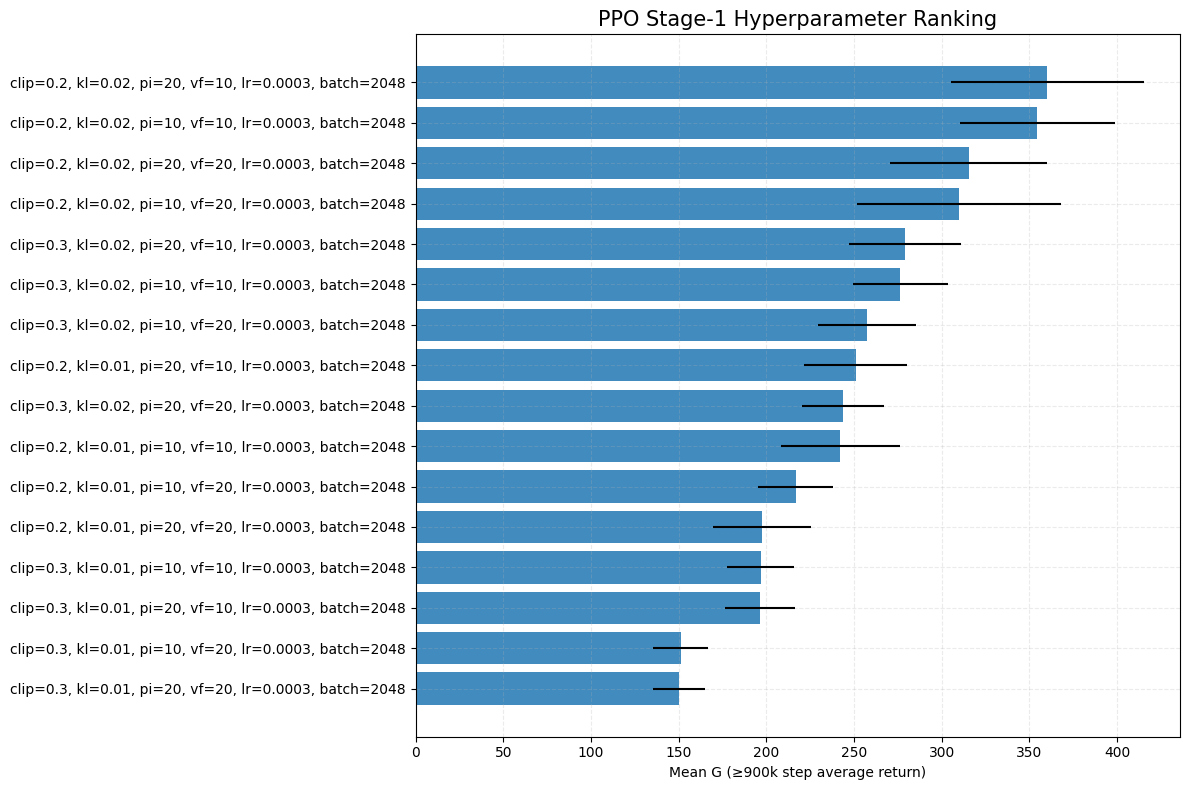

In [15]:
plot_ppo_stage1_results(df_ppo)


In [18]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict



# ============================================================
# Extract TRPO hyperparameters (clean labels)
# ============================================================
def extract_trpo_params(fn):
    """
    Extract ONLY TRPO parameters that actually vary in your sweep.
    """

    delta = re.search(r"delta=([\d\.]+)", fn)
    coeff = re.search(r"backtrack_coeff=([\d\.]+)", fn)
    vf    = re.search(r"train_vf_iters=(\d+)", fn)
    alpha = re.search(r"backtrack_alpha=([\d\.]+)", fn)

    return (
        f"δ={delta.group(1) if delta else '?'}, "
        f"coeff={coeff.group(1) if coeff else '?'}, "
        f"vf={vf.group(1) if vf else '?'}, "
        f"α={alpha.group(1) if alpha else '?'}"
    )



# ============================================================
# Stage-1 Hyperparameter Tuning (TRPO)
# ============================================================
def hyperparam_stage1_decision_trpo(
    log_dir,
    start_step=900_000,
    file_suffixes=(".json", ".jso")
):

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))

    files = []
    for suf in file_suffixes:
        files += list(folder.glob(f"*{suf}"))

    print(f"Found {len(files)} TRPO logs.")
    if not files:
        raise FileNotFoundError("No TRPO logs found!")

    # ---------- Load training curve ----------
    def load_curve(path):
        with path.open("r") as f:
            d = json.load(f)
        events = [e for e in d.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in events])
        avg   = np.array([e.get("average_return", np.nan) for e in events])
        return steps, avg

    # ---------- Group by config (strip seed) ----------
    cfg_groups = defaultdict(list)

    for p in files:
        steps, avg = load_curve(p)
        if len(steps) == 0:
            continue

        cfg = re.sub(r"_seed=\d+", "", p.name)  # remove seed=###
        cfg_groups[cfg].append((steps, avg))

    print(f"Found {len(cfg_groups)} unique TRPO configs.\n")

    # ---------- Compute G for each config ----------
    rows = []

    for cfg, runs in cfg_groups.items():
        G_vals = []
        for steps, avg in runs:
            mask = steps >= start_step
            if np.any(mask):
                G_vals.append(float(np.nanmean(avg[mask])))

        if not G_vals:
            continue

        G_vals = np.array(G_vals)

        rows.append((
            extract_trpo_params(cfg),
            float(np.mean(G_vals)),
            float(np.std(G_vals)),
            float(np.median(G_vals)),
            len(G_vals)
        ))

    # ---------- Build decision table ----------
    df = pd.DataFrame(rows, columns=["Config", "Mean_G", "Std_G", "Median_G", "Num_Runs"])

    df.rename(columns={df.columns[0]: "Config"}, inplace=True)  # force correct name

    df = df.sort_values(by="Mean_G", ascending=False)

    print("📊 TRPO Stage-1 Hyperparameter Decision Table")
    print(df.to_string(
        index=False,
        formatters={
            "Mean_G": "{:,.2f}".format,
            "Std_G": "{:,.2f}".format,
            "Median_G": "{:,.2f}".format
        }
    ))

    print("\n🏆 Best TRPO Config:")
    print(df.iloc[0])

    return df



# ============================================================
# PLOT: TRPO Stage-1 Hyperparameter Ranking
# ============================================================
def plot_trpo_stage1_results(df):
    df = df.copy()
    df.rename(columns={df.columns[0]: "Config"}, inplace=True)

    df_plot = df.sort_values("Mean_G", ascending=True)

    plt.figure(figsize=(12, 8))
    plt.barh(
        df_plot["Config"],
        df_plot["Mean_G"],
        xerr=df_plot["Std_G"],
        color="#ff7f0e",
        alpha=0.85
    )

    plt.xlabel("Mean G (≥900k step average return)")
    plt.title("TRPO Stage-1 Hyperparameter Ranking", fontsize=15)
    plt.grid(alpha=0.25, linestyle="--")
    plt.tight_layout()
    plt.show()


Found 96 TRPO logs.
Found 12 unique TRPO configs.

📊 TRPO Stage-1 Hyperparameter Decision Table
                          Config Mean_G Std_G Median_G  Num_Runs
   δ=0.02, coeff=1, vf=10, α=0.5 121.75 31.62   113.88         8
 δ=0.02, coeff=0.8, vf=10, α=0.5 119.71 10.11   117.22         8
   δ=0.01, coeff=1, vf=10, α=0.5 106.83  6.84   109.19         8
 δ=0.01, coeff=0.8, vf=10, α=0.5  92.00  8.61    91.34         8
 δ=0.02, coeff=0.8, vf=80, α=0.5  24.81  6.02    26.60         8
   δ=0.01, coeff=1, vf=80, α=0.5  24.69  5.74    22.82         8
   δ=0.02, coeff=1, vf=80, α=0.5  22.17  9.73    22.86         8
 δ=0.01, coeff=0.8, vf=80, α=0.5  19.81  6.71    19.73         8
  δ=0.02, coeff=1, vf=120, α=0.5  19.26  5.25    18.28         8
  δ=0.01, coeff=1, vf=120, α=0.5  16.61  8.14    14.94         8
δ=0.02, coeff=0.8, vf=120, α=0.5  16.03 12.55    15.83         8
δ=0.01, coeff=0.8, vf=120, α=0.5  13.31  6.97    13.52         8

🏆 Best TRPO Config:
Config      δ=0.02, coeff=1, vf=10, α=

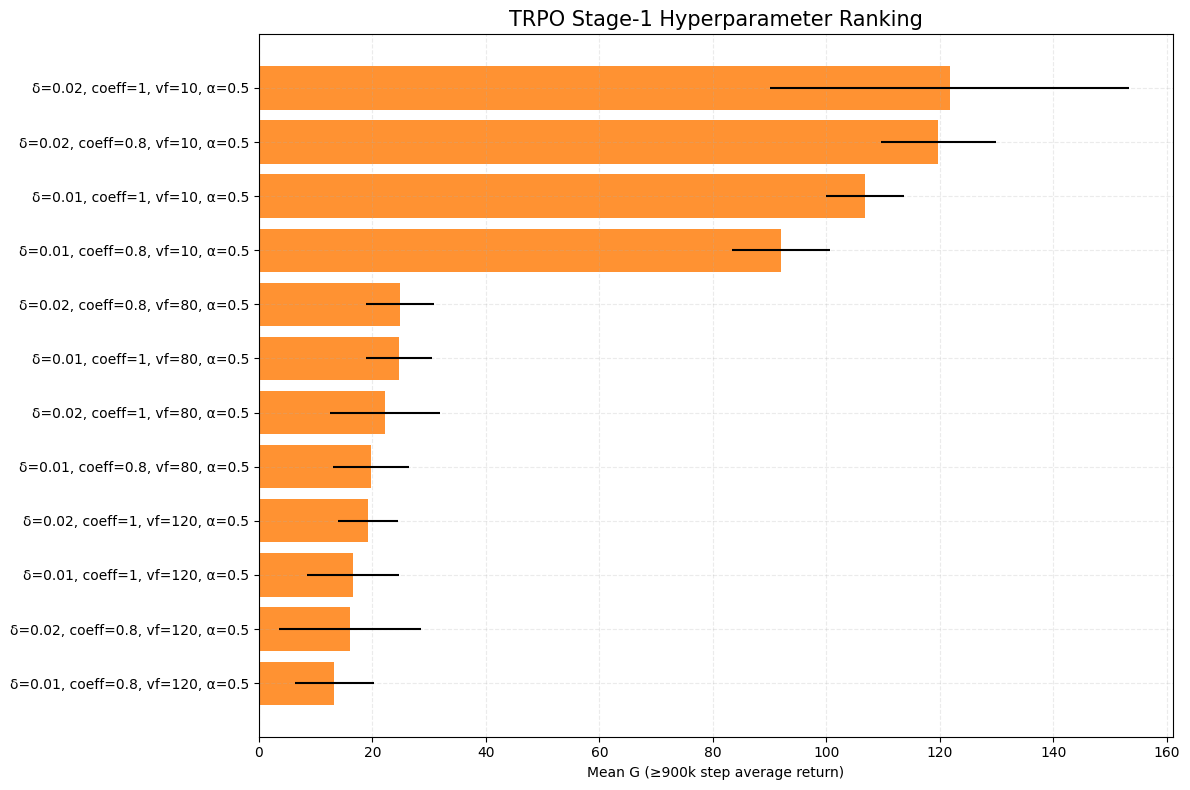

In [19]:
df_trpo = hyperparam_stage1_decision_trpo(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    start_step=900_000
)

plot_trpo_stage1_results(df_trpo)
